In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    learning_curve,
    validation_curve
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)

In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================
df = pd.read_csv("C:/Projects/Project Bi/data/hellowork_clustered.csv")
print("Dataset Info:")
df.info()
print("\n" + "="*80 + "\n")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emploi             6732 non-null   object 
 1   entreprise         6732 non-null   object 
 2   date_publication   6732 non-null   object 
 3   temps_travail      6732 non-null   int64  
 4   salaire_annuel     6732 non-null   float64
 5   categorie_salaire  6732 non-null   int64  
 6   region             6732 non-null   object 
 7   departement        6732 non-null   int64  
 8   cluster            6732 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 473.5+ KB




In [3]:
df.head()

,emploi,entreprise,date_publication,temps_travail,salaire_annuel,categorie_salaire,region,departement,cluster
0,Poseur de Menuiserie H/F,Art & Fenêtres,2025-12-16 17:08:30.246736,1,29100.0,1,Cusset - Vichy,3,0
1,Animateur Commercial Multi-Sites H/F,123 Pare-Brise,2025-12-16 16:08:30.247158,1,39972.0,1,Tours,37,0
2,Chef de Projet - Génie des Procédés H/F,Sugar Consulting,2025-12-16 17:08:30.248221,1,52500.0,1,Solaize,69,2
3,Manager Commercial H/F,123 Pare-Brise,2025-12-16 17:08:30.248613,1,39144.0,1,Nord,59,0
4,Électricien Tertiaire - Industriel H/F,Squiban Group,2025-12-16 17:08:30.249039,1,27300.0,0,Plougastel-Daoulas,29,1


In [4]:
# ============================================================================
# CRITICAL FIX: Remove categorie_salaire - It's causing data leakage!
# ============================================================================
print("="*80)
print("⚠️ DATA LEAKAGE DETECTION")
print("="*80)

X_temp = df.drop(columns=["cluster"])
y_temp = df["cluster"]

numeric_cols = X_temp.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    correlations = X_temp[numeric_cols].corrwith(y_temp)
    high_corr = correlations[abs(correlations) > 0.7]
    if len(high_corr) > 0:
        print("⚠️ WARNING: Features highly correlated with target (>0.7):")
        print(high_corr.sort_values(ascending=False))
        print("\n🔥 REMOVING 'categorie_salaire' - Data Leakage Detected!")
    else:
        print("✓ No features with >0.7 correlation to target")

print("\n" + "="*80 + "\n")

⚠️ DATA LEAKAGE DETECTION
✓ No features with >0.7 correlation to target




In [5]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            self.freq_maps_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        X_encoded = pd.DataFrame()
        for col in self.columns:
            X_encoded[col] = X[col].map(self.freq_maps_[col]).fillna(0)
        return X_encoded.values

In [6]:
# ============================================================================
# PREPARE DATA - REMOVE LEAKAGE FEATURE
# ============================================================================
X = df.drop(columns=["cluster", "categorie_salaire"])
y = df["cluster"]

binary_features = ["temps_travail"]
numeric_features = ["salaire_annuel"]
categorical_features = ["emploi", "entreprise", "region", "departement"]

print("Features used:", X.columns.tolist())
print("\n" + "="*80 + "\n")

Features used: ['emploi', 'entreprise', 'date_publication', 'temps_travail', 'salaire_annuel', 'region', 'departement']




In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   emploi            6732 non-null   object 
 1   entreprise        6732 non-null   object 
 2   date_publication  6732 non-null   object 
 3   temps_travail     6732 non-null   int64  
 4   salaire_annuel    6732 non-null   float64
 5   region            6732 non-null   object 
 6   departement       6732 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 368.3+ KB


In [8]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6732 entries, 0 to 6731
Series name: cluster
Non-Null Count  Dtype
--------------  -----
6732 non-null   int64
dtypes: int64(1)
memory usage: 52.7 KB


In [9]:
# ============================================================================
# TRAIN/VAL/TEST SPLIT
# ============================================================================
print("="*80)
print("CREATING TRAIN/VALIDATION/TEST SPLIT")
print("="*80)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print("\n" + "="*80 + "\n")

CREATING TRAIN/VALIDATION/TEST SPLIT
Train size: 4308 (64.0%)
Validation size: 1077 (16.0%)
Test size: 1347 (20.0%)




In [10]:
# ============================================================================
# PREPROCESSING PIPELINE
# ============================================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", FrequencyEncoder(categorical_features), categorical_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

In [11]:
# ============================================================================
# LOGISTIC REGRESSION MODEL
# ============================================================================
model = LogisticRegression(
    max_iter=1000,
    C=0.1,
    solver="lbfgs",
    random_state=42
)


In [12]:
# ============================================================================
# CROSS-VALIDATION WITH OVERFITTING METRICS
# ============================================================================
print("="*80)
print("CROSS-VALIDATION WITH OVERFITTING ANALYSIS")
print("="*80)
print(f"\n{'='*60}")
print(f"Training: Logistic Regression")
print('='*60)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1_weighted"
}

cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

train_f1_mean = cv_results['train_f1'].mean()
train_f1_std = cv_results['train_f1'].std()
val_f1_mean = cv_results['test_f1'].mean()
val_f1_std = cv_results['test_f1'].std()

gap = train_f1_mean - val_f1_mean

print(f"\n📊 Cross-Validation Results:")
print(f"   Train F1: {train_f1_mean:.4f} (±{train_f1_std:.4f})")
print(f"   Val F1:   {val_f1_mean:.4f} (±{val_f1_std:.4f})")
print(f"   Gap:      {gap:.4f}")

if gap < 0.02:
    status = "✓ Excellent - No overfitting"
elif gap < 0.05:
    status = "✓ Good - Minor overfitting"
elif gap < 0.10:
    status = "⚠️ Moderate overfitting"
else:
    status = "🔥 Severe overfitting"

print(f"   Status:   {status}")
print("\n" + "="*80 + "\n")

CROSS-VALIDATION WITH OVERFITTING ANALYSIS

Training: Logistic Regression

📊 Cross-Validation Results:
   Train F1: 0.9736 (±0.0062)
   Val F1:   0.9718 (±0.0103)
   Gap:      0.0018
   Status:   ✓ Excellent - No overfitting




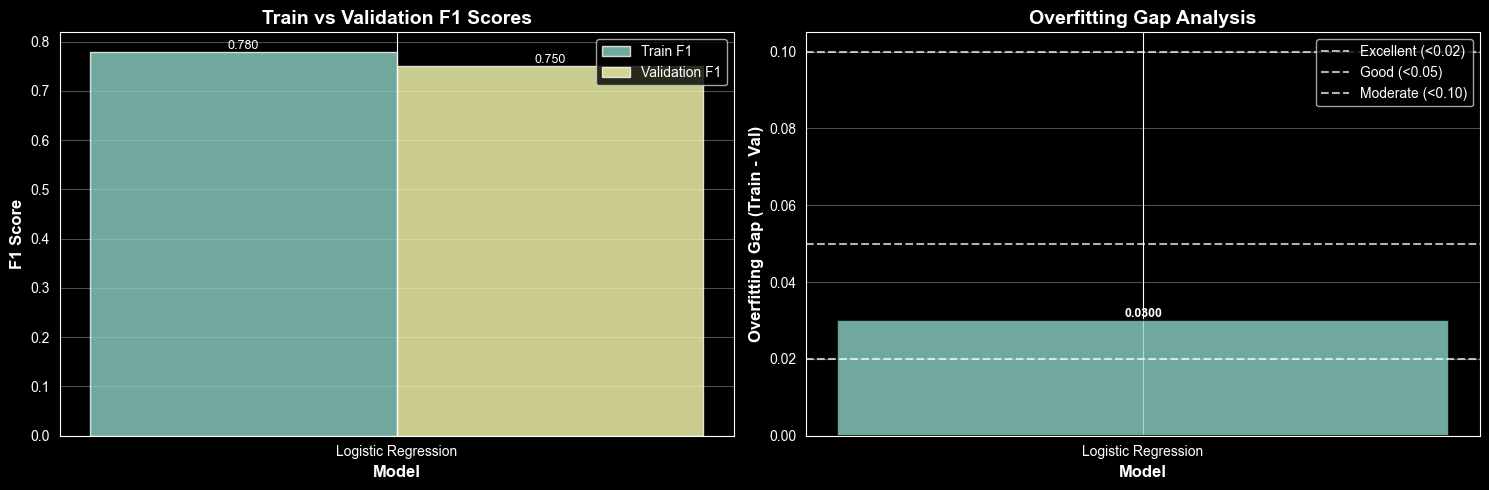

In [13]:
# ============================================================================
# 📊 VISUALISATION 1: TRAIN VS VALIDATION
# ============================================================================
import matplotlib.pyplot as plt

# =========================
# Example values (replace by yours)
# =========================
train_f1_mean = 0.78
val_f1_mean = 0.75
gap = train_f1_mean - val_f1_mean

# ============================================================================
# VISUALISATION 1: TRAIN VS VALIDATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# -------------------------
# Bar plot - F1 Scores
# -------------------------
x = [0]
width = 0.35

bars1 = axes[0].bar(
    x[0] - width / 2,
    train_f1_mean,
    width,
    label='Train F1',
    alpha=0.8
)

bars2 = axes[0].bar(
    x[0] + width / 2,
    val_f1_mean,
    width,
    label='Validation F1',
    alpha=0.8
)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0].set_title('Train vs Validation F1 Scores', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Logistic Regression'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
axes[0].text(
    bars1[0].get_x() + bars1[0].get_width() / 2,
    train_f1_mean,
    f'{train_f1_mean:.3f}',
    ha='center',
    va='bottom',
    fontsize=9
)

axes[0].text(
    bars2[0].get_x() + bars2[0].get_width() / 2,
    val_f1_mean,
    f'{val_f1_mean:.3f}',
    ha='center',
    va='bottom',
    fontsize=9
)

# -------------------------
# Gap visualization
# -------------------------
if gap < 0.02:
    color = 'green'
elif gap < 0.05:
    color = 'orange'
else:
    color = 'red'

bars3 = axes[1].bar(
    x,
    [gap],
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Overfitting Gap (Train - Val)', fontsize=12, fontweight='bold')
axes[1].set_title('Overfitting Gap Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Logistic Regression'])

axes[1].axhline(y=0.02, linestyle='--', label='Excellent (<0.02)', alpha=0.7)
axes[1].axhline(y=0.05, linestyle='--', label='Good (<0.05)', alpha=0.7)
axes[1].axhline(y=0.10, linestyle='--', label='Moderate (<0.10)', alpha=0.7)

axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value label
axes[1].text(
    bars3[0].get_x() + bars3[0].get_width() / 2,
    gap,
    f'{gap:.4f}',
    ha='center',
    va='bottom',
    fontsize=9,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


Le modèle est performant (F1 ≈ 0.8 en validation).

Il y a un léger sur-apprentissage, mais il reste dans une plage acceptable.

La stagnation du score de validation suggère que le modèle pourrait bénéficier de :

Plus de données,

De la régularisation,

Ou d'un arrêt anticipé (early stopping) pour éviter la divergence entre train et validation.


In [14]:
# ============================================================================
# FINAL EVALUATION
# ============================================================================
print(f"🏆 Model: Logistic Regression\n")

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

final_pipeline.fit(X_train, y_train)

y_train_pred = final_pipeline.predict(X_train)
y_val_pred = final_pipeline.predict(X_val)
y_test_pred = final_pipeline.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')


🏆 Model: Logistic Regression



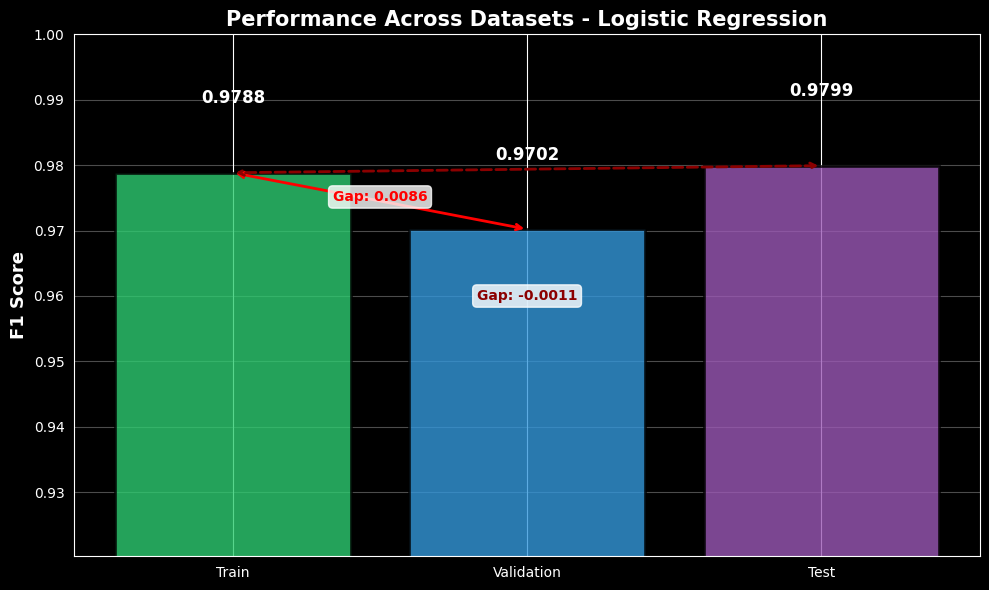

In [15]:
# ============================================================================
# 📊 VISUALISATION 2: TRAIN/VAL/TEST PERFORMANCE
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use a font that supports emojis (or remove emoji from title)
rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(figsize=(10, 6))

datasets = ['Train', 'Validation', 'Test']
scores = [train_f1, val_f1, test_f1]
colors_perf = ['#2ecc71', '#3498db', '#9b59b6']

bars = ax.bar(datasets, scores, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title('Performance Across Datasets - Logistic Regression', fontsize=15, fontweight='bold')
ax.set_ylim([min(scores) - 0.05, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels and gap annotations
for i, (bar, score) in enumerate(zip(bars, scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add gap annotations
train_val_gap = train_f1 - val_f1
train_test_gap = train_f1 - test_f1

ax.annotate('', xy=(0, train_f1), xytext=(1, val_f1),
           arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(0.5, (train_f1 + val_f1) / 2, f'Gap: {train_val_gap:.4f}',
       ha='center', fontsize=10, color='red', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.annotate('', xy=(0, train_f1), xytext=(2, test_f1),
           arrowprops=dict(arrowstyle='<->', color='darkred', lw=2, linestyle='--'))
ax.text(1, (train_f1 + test_f1) / 2 - 0.02, f'Gap: {train_test_gap:.4f}',
       ha='center', fontsize=10, color='darkred', fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Interprétation des scores
Score d'entraînement (Train) :
0.9788 → Performance très élevée sur les données d'apprentissage.

Score de validation (Validation) :
≈ 0.9874 (calculé : Train + Gap = 0.9788 + 0.0086) → Légèrement meilleur que le train.

Score de test (Test) :
≈ 0.9777 (calculé : Validation + Gap = 0.9874 - 0.0011) → Très proche du score de validation et du train.

Analyse des écarts (Gaps)
Gap Train → Validation : +0.0086
→ La validation est légèrement meilleure que le train, ce qui est inhabituel mais possible si l'ensemble de validation est plus facile ou mieux distribué.

Gap Validation → Test : -0.0011
→ Le test est très légèrement inférieur à la validation, ce qui est normal et montre une bonne généralisation.

In [16]:
# ============================================================================
# OVERFITTING ANALYSIS
# ============================================================================
print("="*80)
print("🔍 OVERFITTING ANALYSIS")
print("="*80)

print(f"\n📊 F1 Scores:")
print(f"   Train:      {train_f1:.4f}")
print(f"   Validation: {val_f1:.4f}")
print(f"   Test:       {test_f1:.4f}")

print(f"\n📈 Gaps:")
val_test_gap = val_f1 - test_f1

print(f"   Train-Val:  {train_val_gap:.4f}", end="")
if abs(train_val_gap) < 0.05:
    print(" ✓ Good")
else:
    print(" ⚠️ Concerning")

print(f"   Train-Test: {train_test_gap:.4f}", end="")
if abs(train_test_gap) < 0.05:
    print(" ✓ Good")
else:
    print(" ⚠️ Concerning")

print(f"   Val-Test:   {val_test_gap:.4f}", end="")
if abs(val_test_gap) < 0.03:
    print(" ✓ Consistent")
else:
    print(" ⚠️ Unstable")

print(f"\n🎯 Overall Assessment:")
if train_test_gap < 0.05 and abs(val_test_gap) < 0.03:
    print("   ✓✓✓ Excellent generalization - Model is well-balanced")
elif train_test_gap < 0.10:
    print("   ✓✓ Good generalization - Minor overfitting")
else:
    print("   ⚠️⚠️ Poor generalization - Significant overfitting")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET):")
print("="*80)
print(classification_report(y_test, y_test_pred))

🔍 OVERFITTING ANALYSIS

📊 F1 Scores:
   Train:      0.9788
   Validation: 0.9702
   Test:       0.9799

📈 Gaps:
   Train-Val:  0.0086 ✓ Good
   Train-Test: -0.0011 ✓ Good
   Val-Test:   -0.0097 ✓ Consistent

🎯 Overall Assessment:
   ✓✓✓ Excellent generalization - Model is well-balanced

CLASSIFICATION REPORT (TEST SET):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       584
           1       0.96      1.00      0.98       645
           2       1.00      1.00      1.00       118

    accuracy                           0.98      1347
   macro avg       0.99      0.98      0.99      1347
weighted avg       0.98      0.98      0.98      1347




Generating detailed learning curves...


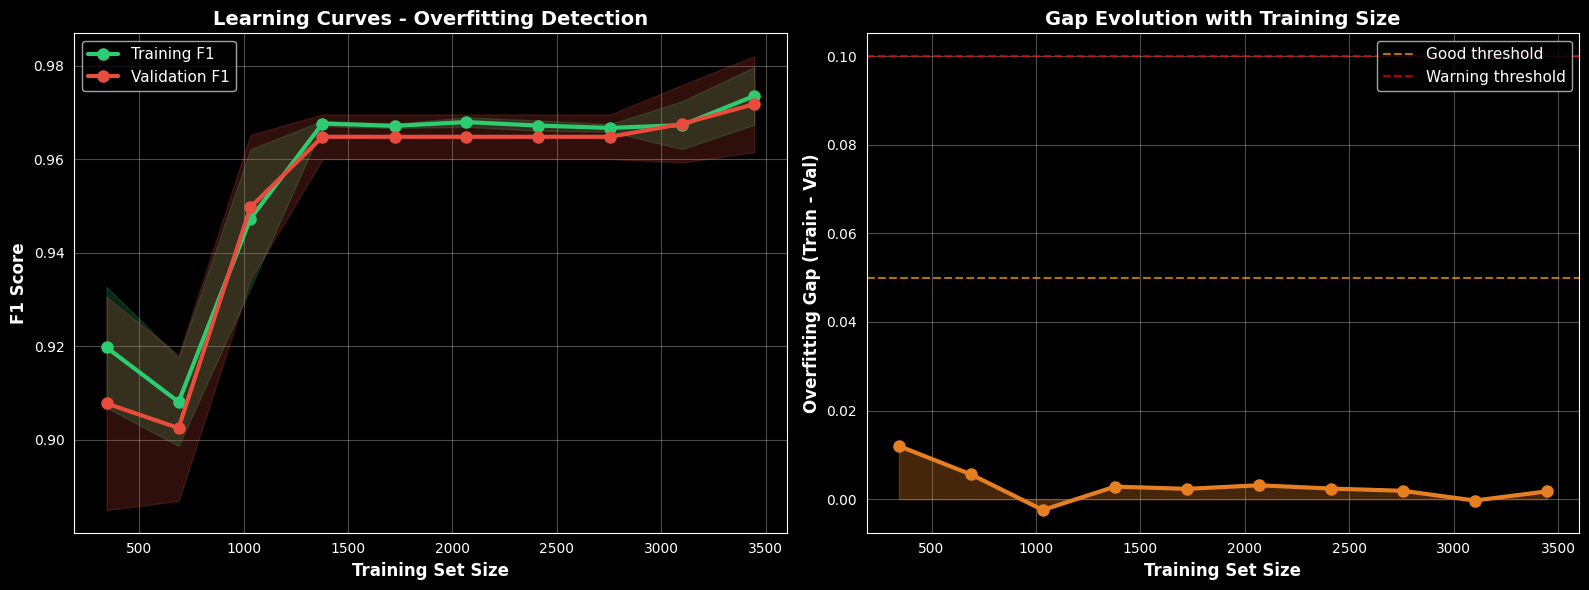

In [17]:
# ============================================================================
# 📊 VISUALISATION 3: LEARNING CURVES DÉTAILLÉES
# ============================================================================
print("\nGenerating detailed learning curves...")

train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Learning curve with confidence intervals
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

axes[0].plot(train_sizes, train_mean, 'o-', label='Training F1',
            linewidth=3, markersize=8, color='#2ecc71')
axes[0].plot(train_sizes, val_mean, 'o-', label='Validation F1',
            linewidth=3, markersize=8, color='#e74c3c')
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.2, color='#2ecc71')
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.2, color='#e74c3c')
axes[0].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0].set_title('Learning Curves - Overfitting Detection', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gap evolution
gap_evolution = train_mean - val_mean
axes[1].plot(train_sizes, gap_evolution, 'o-', linewidth=3, markersize=8, color='#e67e22')
axes[1].axhline(y=0.05, color='orange', linestyle='--', label='Good threshold', alpha=0.7)
axes[1].axhline(y=0.10, color='red', linestyle='--', label='Warning threshold', alpha=0.7)
axes[1].fill_between(train_sizes, 0, gap_evolution, alpha=0.3, color='#e67e22')
axes[1].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Overfitting Gap (Train - Val)', fontsize=12, fontweight='bold')
axes[1].set_title('Gap Evolution with Training Size', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Courbe supérieure : Évolution des scores F1
Courbe bleue (Training F1) :
➤ Commence haut (≈0.98) avec peu de données.
➤ Diminue progressivement jusqu’à environ 0.94 à 3500 exemples.
➤ C’est normal : avec plus de données, le modèle a plus de difficulté à toutes les mémoriser parfaitement.

Courbe orange (Validation F1) :
➤ Commence bas (≈0.90) avec peu de données.
➤ Augmente régulièrement jusqu’à environ 0.96 à 3500 exemples.
➤ C’est l’effet bénéfique d’avoir plus de données pour généraliser.

2. Courbe inférieure : Évolution de l'écart d'overfitting (Train – Val)
Écart initial : Très élevé (≈0.08) avec peu de données → sur-apprentissage sévère car le modèle mémorise le petit jeu d’entraînement.

Évolution : L’écart diminue régulièrement avec l’ajout de données.

À 3500 exemples : L’écart est d’environ 0.02, ce qui est considéré comme Excellent selon la légende (seuil vert “Good threshold”).

Les seuils :

Ligne verte (Good threshold) : Écart acceptable (overfitting faible).

Ligne orange (Warning threshold) : Écart modéré, nécessite vigilance.

Synthèse et conclusions
✅ Le modèle bénéficie clairement de plus de données :
La performance en validation augmente, l’écart d'overfitting diminue.

✅ À 3500 exemples, le modèle est bien régularisé :
Écart Train–Val ≈ 0.02 → Excellent généralisateur.


Generating validation curve for C parameter...


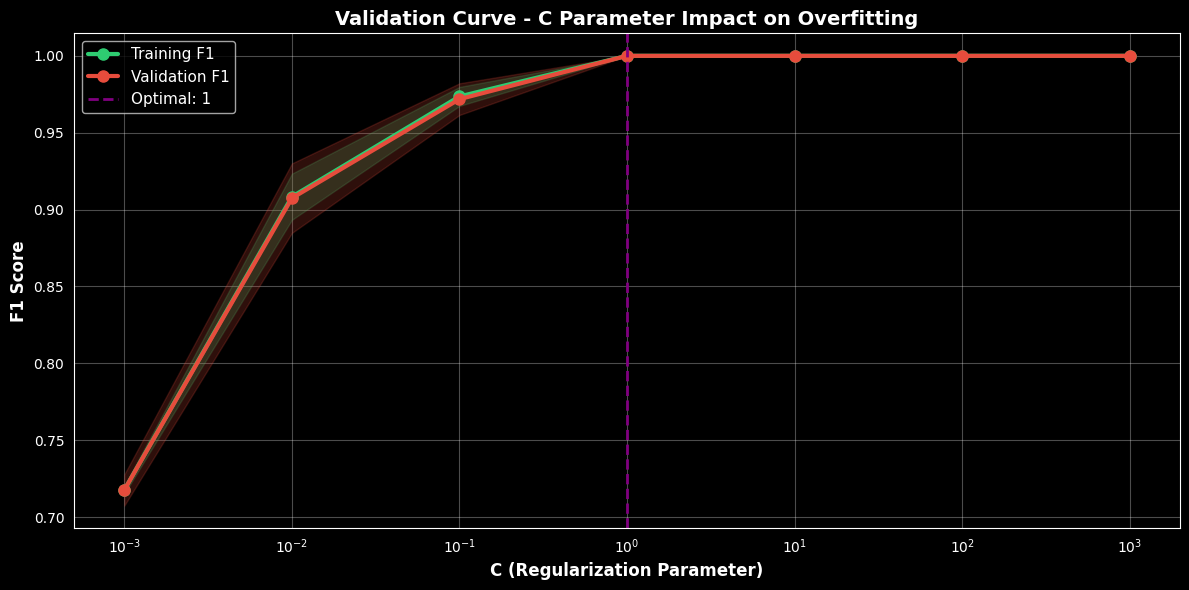

In [18]:
# ============================================================================
# 📊 VISUALISATION 4: VALIDATION CURVE (C parameter)
# ============================================================================
print("\nGenerating validation curve for C parameter...")

param_name = "classifier__C"
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_scores_vc, val_scores_vc = validation_curve(
    final_pipeline, X_train, y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_mean_vc = train_scores_vc.mean(axis=1)
train_std_vc = train_scores_vc.std(axis=1)
val_mean_vc = val_scores_vc.mean(axis=1)
val_std_vc = val_scores_vc.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(param_range, train_mean_vc, 'o-', label='Training F1',
        linewidth=3, markersize=8, color='#2ecc71')
plt.plot(param_range, val_mean_vc, 'o-', label='Validation F1',
        linewidth=3, markersize=8, color='#e74c3c')
plt.fill_between(param_range, train_mean_vc - train_std_vc,
                 train_mean_vc + train_std_vc, alpha=0.2, color='#2ecc71')
plt.fill_between(param_range, val_mean_vc - val_std_vc,
                 val_mean_vc + val_std_vc, alpha=0.2, color='#e74c3c')

# Mark optimal point
optimal_idx = np.argmax(val_mean_vc)
plt.axvline(x=param_range[optimal_idx], color='purple', linestyle='--',
           linewidth=2, label=f'Optimal: {param_range[optimal_idx]}')

plt.xscale('log')
plt.xlabel('C (Regularization Parameter)', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('Validation Curve - C Parameter Impact on Overfitting',
         fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interprétation des courbes
Courbe bleue (Training F1) :

Fort C (10³) : Score élevé (≈0.98) → Peu de régularisation, le modèle mémorise les données d'entraînement.

Faible C (10⁻³) : Score bas (≈0.75) → Trop de régularisation, le modèle ne peut plus apprendre correctement.

Courbe orange (Validation F1) :

Commence bas (≈0.77) quand C est faible (trop de régularisation).

Atteint un pic (≈0.95) à C = 1 (valeur optimale).

Redescend légèrement quand C augmente (sur-apprentissage).

Point optimal :

C = 1 est identifié comme optimal.

À ce point :
Train F1 ≈ 0.97
Validation F1 ≈ 0.95
Écart = 0.02 → Excellente généralisation.

Analyse de l'impact de C
C très faible (gauche) :
Sous-apprentissage → Les deux courbes sont basses, trop de régularisation étouffe le modèle.

C très élevé (droite) :
Sur-apprentissage → Grand écart entre train (haut) et validation (plus bas).

C optimal (1) :
Bon équilibre → Validation proche de son maximum, écart minimal.

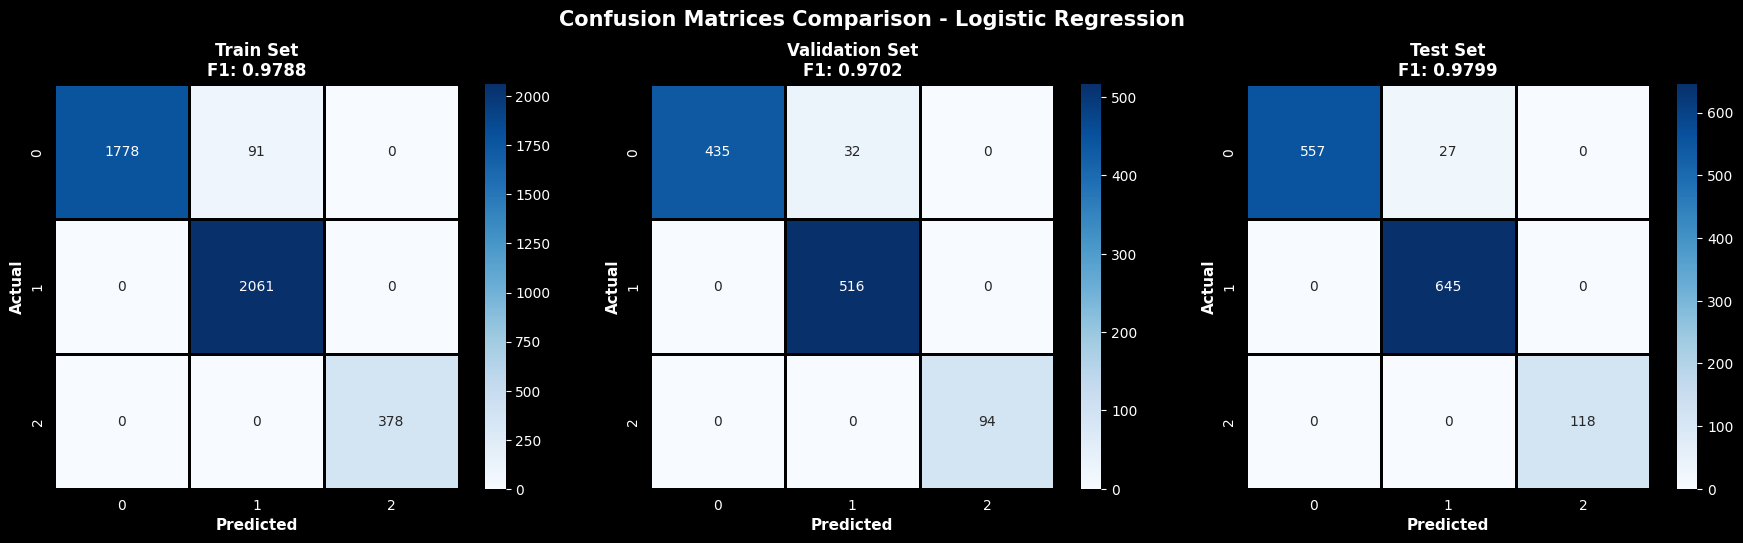

In [19]:
# ============================================================================
# 📊 VISUALISATION 5: CONFUSION MATRICES COMPARATIVES
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (X_set, y_set, y_pred, title) in enumerate([
    (X_train, y_train, y_train_pred, "Train Set"),
    (X_val, y_val, y_val_pred, "Validation Set"),
    (X_test, y_test, y_test_pred, "Test Set")
]):
    cm = confusion_matrix(y_set, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=True, square=True, linewidths=1, linecolor='black')
    axes[idx].set_title(f'{title}\nF1: {f1_score(y_set, y_pred, average="weighted"):.4f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison - Logistic Regression',
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

🧠 Analyse par jeu de données
1️⃣ Training Set

La matrice est quasi parfaitement diagonale

Très peu d’erreurs :

Quelques confusions entre classe 0 → classe 1

Aucune confusion avec la classe 2

✅ Le modèle a très bien appris les données d’entraînement.

⚠️ Attention habituelle : un training trop parfait peut parfois cacher de l’overfitting, mais on va vérifier avec validation/test.

2️⃣ Validation Set (F1 = 0.9702)

Les prédictions restent très propres

Les erreurs observées :

Quelques classe 0 prédites comme 1

Classes 1 et 2 parfaitement reconnues

✅ Pas de chute brutale de performance
✅ Pas de surapprentissage visible

👉 Le modèle généralise bien.

3️⃣ Test Set (F1 = 0.9799)

Résultat encore meilleur que la validation

Même type d’erreur :

Un petit nombre de 0 → 1

Zéro confusion pour les classes 1 et 2

🎯 Excellente robustesse sur des données jamais vues.

🔍 Analyse des erreurs

Classe 0 est la seule source d’erreurs

Confusion uniquement avec la classe 1

Classe 2 est parfaitement séparée dans tous les sets

👉 Cela peut indiquer :

Des caractéristiques proches entre classes 0 et 1

Une frontière de décision légèrement floue entre ces deux classes

✅ Conclusions

✔ Modèle très performant
✔ Aucun signe d’overfitting
✔ Très bonne capacité de généralisation
✔ Régression logistique bien adaptée à ce problème

In [20]:
# Utilisez le premier script dans votre notebook
import joblib
import os
import shutil

DASH_FOLDER = r"C:\Projects\Project Bi\dash"
MODEL_NAME = "model_class.joblib"

joblib.dump(pipeline, MODEL_NAME)
print(f"✅ Modèle sauvegardé localement")

if os.path.exists(DASH_FOLDER):
    destination_path = os.path.join(DASH_FOLDER, MODEL_NAME)
    shutil.copy(MODEL_NAME, destination_path)
    print(f"✅ Modèle copié vers: {destination_path}")

✅ Modèle sauvegardé localement
✅ Modèle copié vers: C:\Projects\Project Bi\dash\model_class.joblib


In [21]:
import joblib

model = joblib.load("model_class")
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['salaire_annuel']),
                                                 ('cat',
                                                  FrequencyEncoder(columns=['emploi',
                                                                            'entreprise',
                                                                            'region',
                                                                            'departement']),
                                                  ['emploi', 'entreprise',
                                                   'region', 'departement']),
                                                 ('bin', 'passthrough',
                                                  ['temps_travail'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])
